# Google Object Detection API Wrapper Walkthrough

### Dependencies (Import)

In [1]:
import time
import os

import tensorflow as tf
import pandas as pd
import numpy as np

import helpers

### Default Parameters

In [2]:
MODEL_NAME = 'ssd_mobilenet_v1_coco_11_06_2017' # Name of the model you want to use
PATH_TO_LABELS = os.path.join('object_detection/data', 'mscoco_label_map.pbtxt') # Path of class labels
N_THREADS = 64 # Number of threads
BATCH_SIZE = 1 # Batch size (Changing this is strongly not recommended)
VISUALIZE = False # Whether you want to visualize object detection results or not
JSON_OUTPUT_FILE = 'output.json' # Name of the output file that will contain the object detection results

### Parameters

In [3]:
model_name = MODEL_NAME
model_file = 'detection_model_zoo/' + model_name + '.tar.gz' # Path to downloaded model file (.tar)
path_to_ckpt = model_name + '/frozen_inference_graph.pb' # Path to frozen model file

url_file = 'Imagenet_sample_images' # Name of the file containing image ids and urls (without extension)
json_url_file = url_file + '.json' # Name of the json file containing image ids and urls
csv_url_file = url_file + '.csv' # Name of the csv file containing image ids and urls

downloaded = True # Whether you have downloaded the model file or not

json_output_file = JSON_OUTPUT_FILE
n_threads = N_THREADS
visualize = True
path_to_labels = PATH_TO_LABELS

### Model Execution

Converting Image 1
Image 1 Conversion Time: 3.273216724395752 sec
Converting Image 2
Image 2 Conversion Time: 0.982109785079956 sec
Converting Image 3
Image 3 Conversion Time: 1.0177068710327148 sec
Converting Image 4
Image 4 Conversion Time: 1.0327458381652832 sec
Total Image Conversion Time: 6.305779218673706 sec
Total Time Consumed: 7.436934471130371 sec


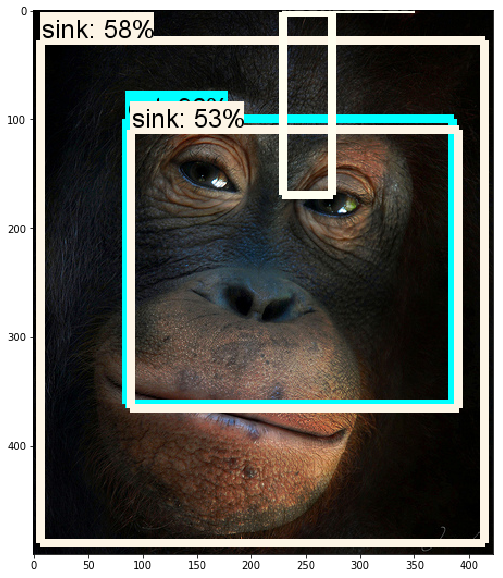

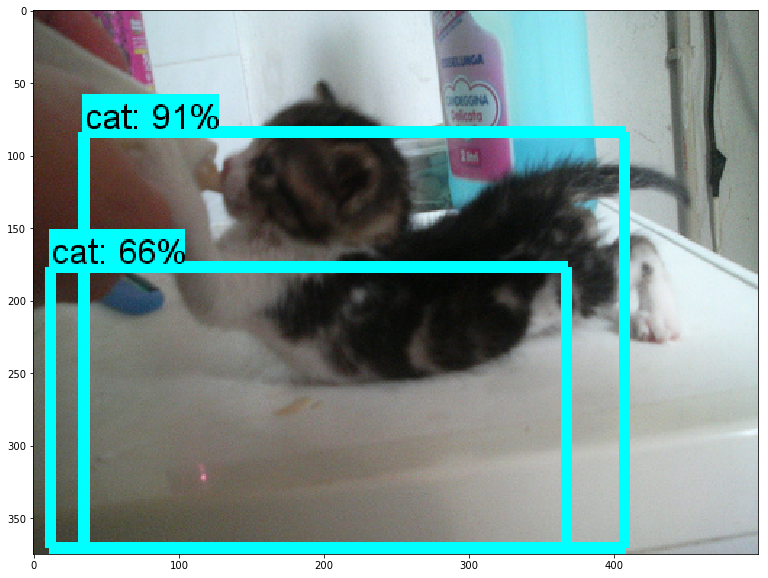

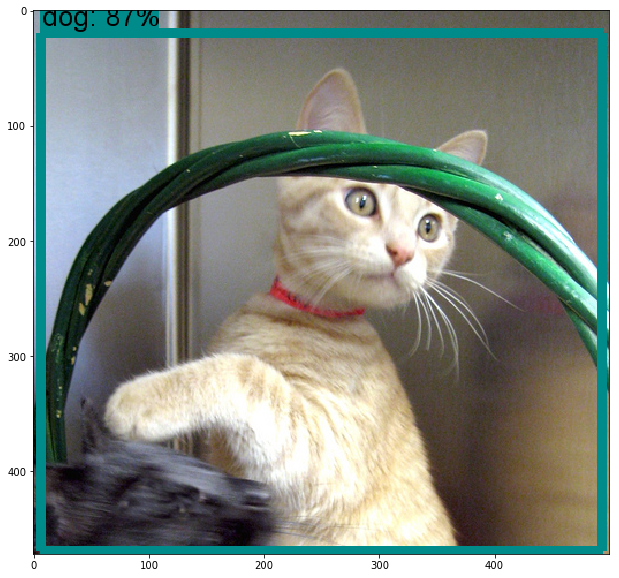

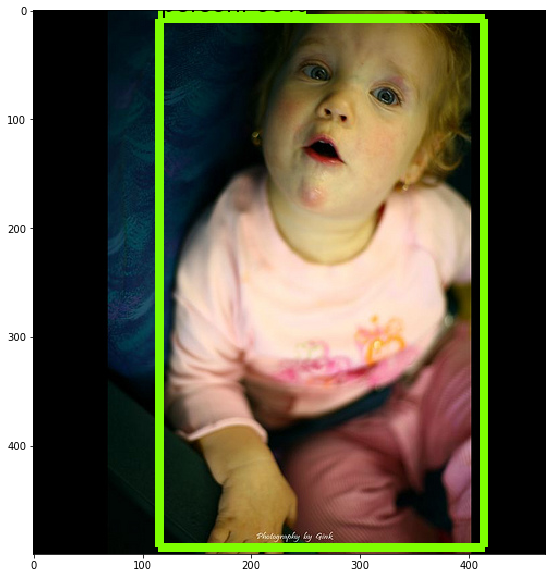

In [4]:
# Download .tar model file and extract the frozen model into a separate directory
helpers.download_extract_model(model_file=model_file, downloaded=downloaded)

# Convert .json file containing image ids and urls into a csv file
helpers.json2csv(json_name=json_url_file, csv_name=csv_url_file)

# Reading csv file
li = pd.read_csv(csv_url_file)
url_li = li['img_url'].tolist()
id_li = li['img_id'].tolist()

# Creating model graph
detection_graph = tf.Graph()
with detection_graph.as_default():
    od_graph_def = tf.GraphDef()
    with tf.gfile.GFile(path_to_ckpt, 'rb') as fid:
        serialized_graph = fid.read()
        od_graph_def.ParseFromString(serialized_graph)
        tf.import_graph_def(od_graph_def, name='')

# Model Execution!
with detection_graph.as_default():
    im = helpers.url_image_reader(url_li)

    queue = tf.PaddingFIFOQueue(capacity=500, dtypes=tf.uint8, shapes=[(None, None, None)])
    enq_op = queue.enqueue(im)
    inputs = queue.dequeue_many(BATCH_SIZE)
    qr = tf.train.QueueRunner(queue, [enq_op] * n_threads)

    with tf.Session(graph=detection_graph) as sess:

        sess.run(tf.global_variables_initializer())
        coord = tf.train.Coordinator()
        enqueue_threads = qr.create_threads(sess=sess, coord=coord, start=True)

        conversion_time = []
        ix = 1
        res = {}

        category_index = helpers.load_category_index(path_to_labels)

        t = time.time()

        try:
            while not coord.should_stop():
                image = sess.run(inputs)  # Tensor of dimension (1, None, None, 3)

                print('Converting Image', ix)

                image_tensor = detection_graph.get_tensor_by_name('image_tensor:0')
                boxes = detection_graph.get_tensor_by_name('detection_boxes:0')
                scores = detection_graph.get_tensor_by_name('detection_scores:0')
                classes = detection_graph.get_tensor_by_name('detection_classes:0')
                num_detections = detection_graph.get_tensor_by_name('num_detections:0')

                t2 = time.time()
                
                # The results of object detection
                (boxes, scores, classes, num_detections) = sess.run([boxes, scores, classes, num_detections],
                                                                    feed_dict={image_tensor: image})

                conversion_time.append(time.time() - t2)

                print('Image', ix, 'Conversion Time:', conversion_time[ix - 1], 'sec')

                # Add results to result dictionary
                res[id_li[ix - 1]] = {'boxes': np.squeeze(boxes),
                                      'scores': np.squeeze(scores),
                                      'classes': np.squeeze(classes).astype(np.int32),
                                      'num_detections': num_detections}

                ix += 1

        except tf.errors.OutOfRangeError:
            print('Total Image Conversion Time:', sum(conversion_time), 'sec')
            print('Total Time Consumed:', time.time() - t, 'sec')

        finally:
            coord.request_stop()
            
            # Dump the contents of the result dictionary into a json file
            helpers.dict2json(res, json_output_file)

            if visualize:
                # If visualize==True, visualize the object recognition results
                helpers.visualize(csv_url_file, res, category_index, image_size=(15, 10))

        coord.join(enqueue_threads)

### Additional helpers.py functions

In [5]:
# Read the dumped json file
res = helpers.json2dict(json_output_file)

# Print the detection results of an image
print(res['n00004475_15899'])

{'classes': array([17, 17, 62, 17, 17, 67, 62, 17, 17, 17,  1, 63, 17, 32, 17, 17, 17,
       17, 67, 17, 17, 67, 67, 17, 64, 64, 17, 63, 17, 64, 15, 17, 17, 62,
       64, 63, 18, 62, 62, 17, 62,  1,  1, 64, 17, 17, 17, 32, 64, 32,  1,
       17, 17, 67,  1, 62, 64, 62, 63, 32, 32,  1, 63, 64, 33,  1, 17, 17,
        2, 17,  2, 32, 62, 62, 50, 17, 17, 63,  2, 64, 32,  1, 17, 62, 63,
       17, 64, 62, 64, 62, 62, 50, 17, 63, 62, 17, 48, 62, 49, 82]), 'num_detections': array([ 100.]), 'scores': array([ 0.9194417 ,  0.66125041,  0.09068324,  0.07147893,  0.06544924,
        0.06501905,  0.06241577,  0.0549518 ,  0.05009558,  0.0500397 ,
        0.04945   ,  0.04757557,  0.04589136,  0.04585449,  0.04414421,
        0.04176405,  0.0405597 ,  0.04055171,  0.03985674,  0.03769663,
        0.03700102,  0.03656044,  0.03550656,  0.03531868,  0.03450224,
        0.03155955,  0.03095494,  0.03059838,  0.03016325,  0.02910231,
        0.02876339,  0.02870041,  0.02841947,  0.02803559,  0.028017

In [6]:
# Threshold result accuracy (remove any detections whose confidence is below 0.9)
thresh_res = helpers.threshold_accuracy(0.9, res)
print(thresh_res)

{'n00004475_32312': {'classes': array([17]), 'num_detections': [1], 'scores': array([ 0.96267915]), 'boxes': array([[ 0.20097306,  0.20227188,  0.72226834,  0.9130792 ]])}, 'n00004475_15899': {'classes': array([17]), 'num_detections': [1], 'scores': array([ 0.9194417]), 'boxes': array([[ 0.22561765,  0.06930083,  0.98819554,  0.81659514]])}, 'n00004475_35466': {'classes': array([], dtype=int32), 'num_detections': [0], 'scores': array([], dtype=float64), 'boxes': array([], shape=(0, 4), dtype=float64)}, 'n00004475_6590': {'classes': array([1]), 'num_detections': [1], 'scores': array([ 0.93609202]), 'boxes': array([[ 0.01798925,  0.24556664,  0.98731339,  0.87918544]])}}


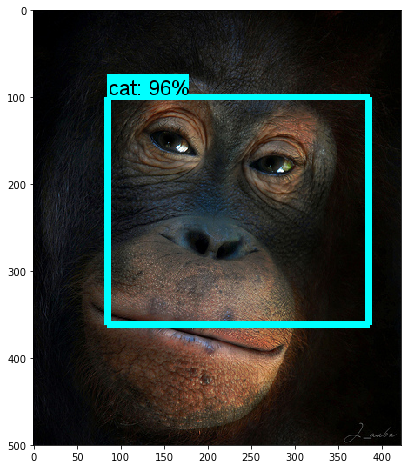

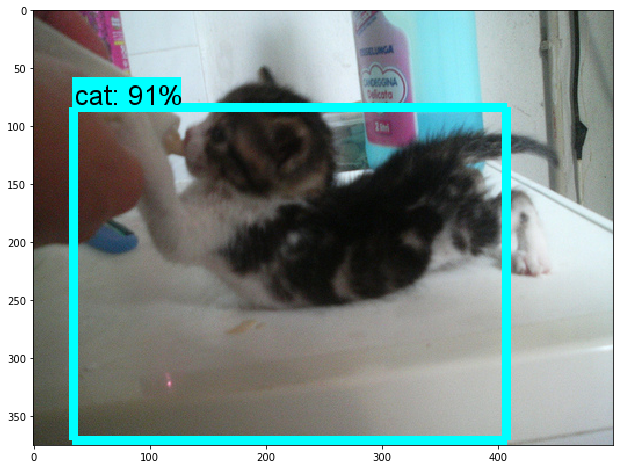

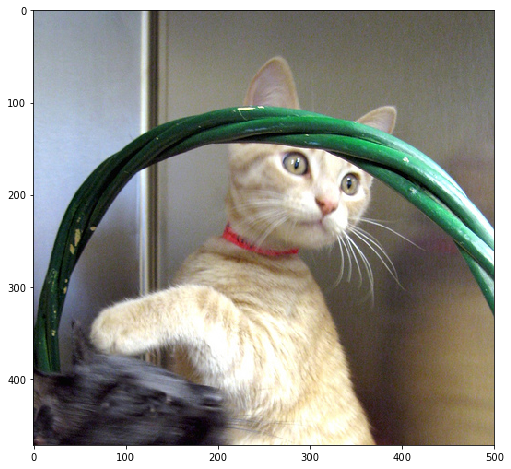

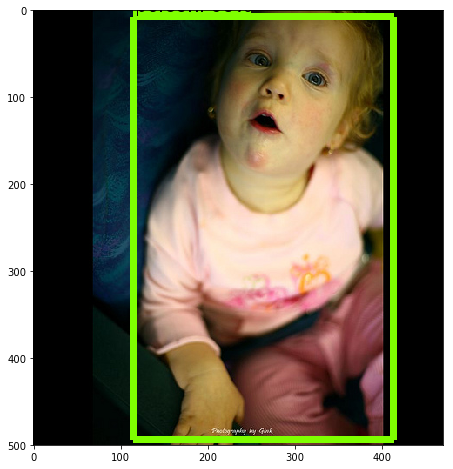

In [7]:
# Visualize thresholded accuracy results
helpers.visualize(csv_url_file, thresh_res, category_index)

In [8]:
# Convert class values to string that explicitly indicate which class
string_res = helpers.class2str(category_index, res)

# Print the converted detection results of an image
print(string_res['n00004475_15899'])

{'classes': ['cat', 'cat', 'chair', 'cat', 'cat', 'dining table', 'chair', 'cat', 'cat', 'cat', 'person', 'couch', 'cat', 'tie', 'cat', 'cat', 'cat', 'cat', 'dining table', 'cat', 'cat', 'dining table', 'dining table', 'cat', 'potted plant', 'potted plant', 'cat', 'couch', 'cat', 'potted plant', 'bench', 'cat', 'cat', 'chair', 'potted plant', 'couch', 'dog', 'chair', 'chair', 'cat', 'chair', 'person', 'person', 'potted plant', 'cat', 'cat', 'cat', 'tie', 'potted plant', 'tie', 'person', 'cat', 'cat', 'dining table', 'person', 'chair', 'potted plant', 'chair', 'couch', 'tie', 'tie', 'person', 'couch', 'potted plant', 'suitcase', 'person', 'cat', 'cat', 'bicycle', 'cat', 'bicycle', 'tie', 'chair', 'chair', 'spoon', 'cat', 'cat', 'couch', 'bicycle', 'potted plant', 'tie', 'person', 'cat', 'chair', 'couch', 'cat', 'potted plant', 'chair', 'potted plant', 'chair', 'chair', 'spoon', 'cat', 'couch', 'chair', 'cat', 'fork', 'chair', 'knife', 'refrigerator'], 'num_detections': array([ 100.]), '